In [1]:
install.packages("igraph")
install.packages("resample")
install.packages("Matrix")
install.packages("pracma")


  There is a binary version available but the source version is later:
       binary source needs_compilation
igraph  1.2.6  1.4.2              TRUE

  Binaries will be installed
package 'igraph' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\yaman\AppData\Local\Temp\RtmpG4kqu3\downloaded_packages

  There is a binary version available but the source version is later:
         binary source needs_compilation
resample    0.4    0.6             FALSE



installing the source package 'resample'




  There is a binary version available but the source version is later:
       binary source needs_compilation
Matrix  1.3-3  1.5-4              TRUE

  Binaries will be installed
package 'Matrix' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\yaman\AppData\Local\Temp\RtmpG4kqu3\downloaded_packages

  There is a binary version available but the source version is later:
       binary source needs_compilation
pracma  2.3.3  2.4.2             FALSE



installing the source package 'pracma'



In [2]:
library(igraph)
library(resample) 
library(Matrix)
library(pracma)

Warning message:
"package 'igraph' was built under R version 3.6.3"
Attaching package: 'igraph'

The following objects are masked from 'package:stats':

    decompose, spectrum

The following object is masked from 'package:base':

    union

Warning message:
"package 'Matrix' was built under R version 3.6.3"
Attaching package: 'pracma'

The following objects are masked from 'package:Matrix':

    expm, lu, tril, triu



In [3]:
#p(i,j) -> probability of jumping from node i to node j
compute_transition_matrix = function (graph){
     
    n_nodes = gorder(graph) # number of nodes
    Aij = as_adjacency_matrix(graph) # get adjacency matrix, Aij
    Aij[diag(rowSums(Aij) == 0)] = 1  #handle dead ends
    degrees_out = matrix(rowSums(Aij, , 1))

    transition_matrix = Aij / repmat(a=degrees_out, n=1, m=n_nodes)  # probabilities 1/degrees_out_node_i
    
    return(transition_matrix)
}

In [4]:
simulate_random_walk = function (graph, n_steps, start_node, teleport_mode="equal",teleport_prob=0.0){

    transition_matrix = compute_transition_matrix(graph)    
    n_nodes = gorder(graph)
    
    if(teleport_mode == "equal"){
        node_teleport_prob = array(1/n_nodes, n_nodes) #equal teleportation
    }else if(teleport_mode == "page_rank"){ # page rank teleportation
        g_page_rank=page_rank(graph, directed=TRUE)$vector
        node_teleport_prob=g_page_rank/sum(g_page_rank)
    }else if( teleport_mode == "page_rank_median"){
        g_page_rank=page_rank(graph, directed=TRUE)$vector
        
        df_temp = data.frame("idx"=1:n_nodes, "val"= g_page_rank)
        df_temp_ordered = df_temp[order(df_temp$val),]
        
        node_teleport_prob=array(0, n_nodes)
        node_teleport_prob[df_temp_ordered$idx[(n_nodes %/% 2):(n_nodes %/% 2) + 1]]=0.5
    }else{
        print("Wrong teleportation mode")
    }
        
    node_path = array(0, n_steps)
    current_node = start_node
    for(i in 1:n_steps){
        
        random_number = runif(1) # uniform sampling between [0,1]
        if(random_number < teleport_prob){
            current_node = sample(1:n_nodes, 1, prob = node_teleport_prob)   
        }
        else{
            p_current_node_j = transition_matrix[current_node, ]
            current_node = sample(1:n_nodes, 1, prob = p_current_node_j)   
        }     
        node_path[i] = current_node
    }
    
    return(node_path) # get the path that is simulated with random walk
}

In [5]:
count_simulate_random_walk = function(graph, n_steps=1000, n_random_walk = 100, teleport_prob=0.0, teleport_mode="equal"){
    
    n_nodes = gorder(graph)
    n_visits=array(0, n_nodes)

    n_convergence = ceiling(log(n_nodes)) # #of steps required for convergence
    for(i in 1:n_random_walk){
        start_node = sample(1:n_nodes, 1)
        node_path = simulate_random_walk(graph = graph, n_steps = n_steps , 
                                       start_node = start_node, 
                                       teleport_mode=teleport_mode,
                                       teleport_prob=teleport_prob)
        
        for (j in 1:length(node_path)) {
            if (j > n_convergence) {
                n_visits[node_path[j]] = n_visits[node_path[j]] + 1 # start counting visits after convergence
            }
        }
    }
    return (n_visits / ((n_steps-n_convergence) * n_random_walk))
}

In [6]:
set.seed(42)
graph_1 <- sample_pa(n=900, m=4, directed=TRUE)
graph_2 <- sample_pa(n=900, m=4, directed=TRUE)

In [7]:
graph_2_shuffled <- permute(graph_2, sample(gorder(graph_2)))

In [8]:
graph_combined = add_edges(graph_1, c(t(as_edgelist(graph_2_shuffled))))

In [9]:
print(ecount(graph_combined))

[1] 7180


In [10]:
no_teleport_visit = count_simulate_random_walk(graph_combined)

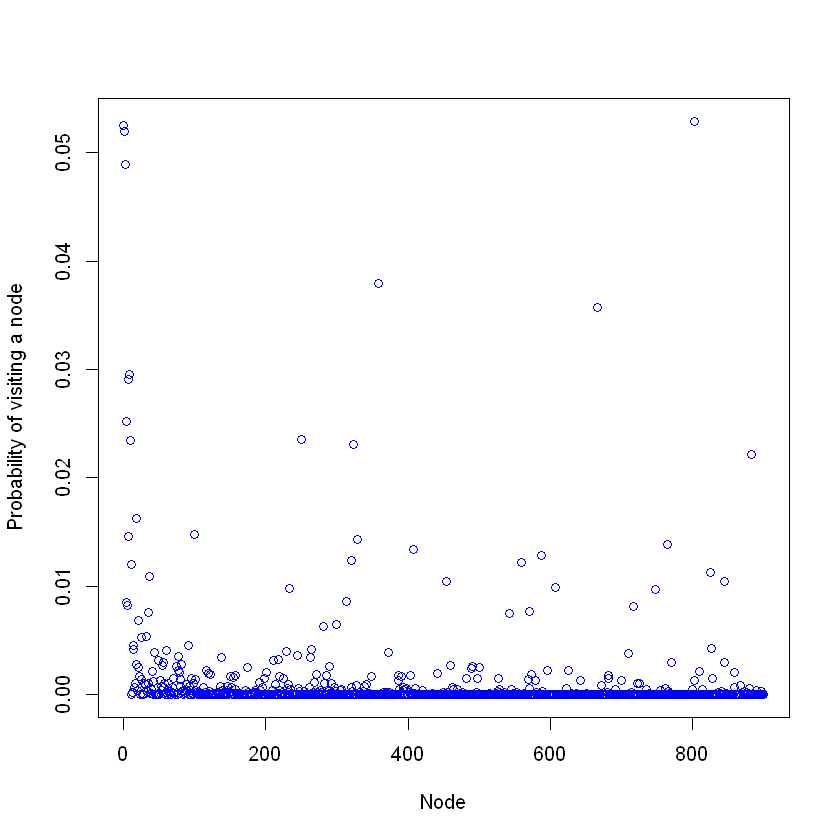

In [11]:
plot(no_teleport_visit,col = "blue",xlab='Node', ylab='Probability of visiting a node')

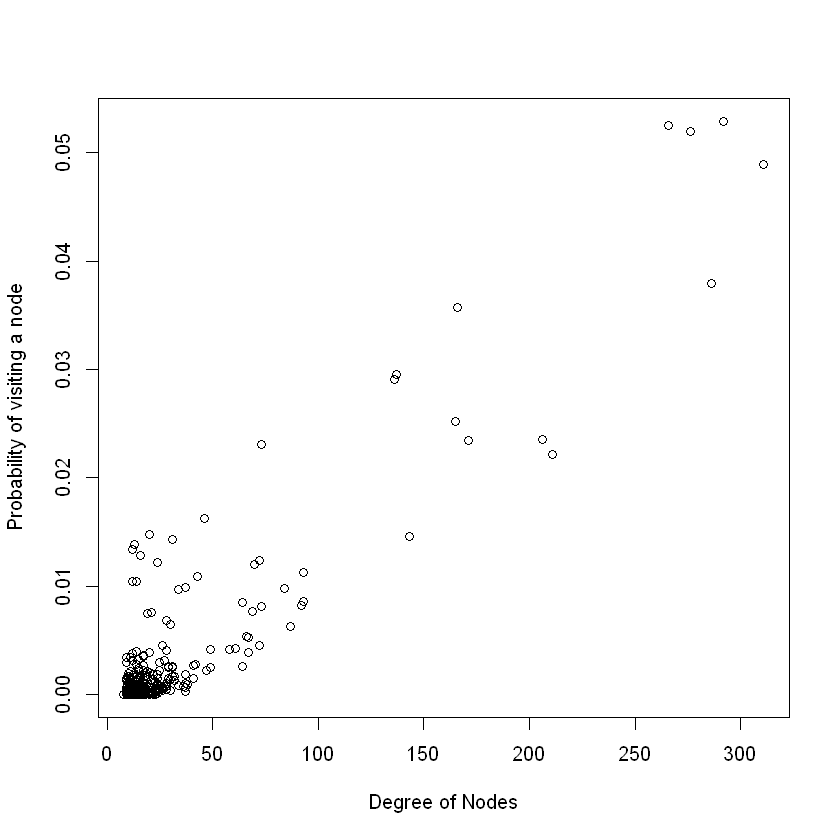

In [12]:
plot(degree(graph_combined), no_teleport_visit, xlab='Degree of Nodes', ylab='Probability of visiting a node')

[1] 0.9213344

Call:
lm(formula = no_teleport_visit ~ degree(graph_combined))

Coefficients:
           (Intercept)  degree(graph_combined)  
             -0.001474                0.000162  



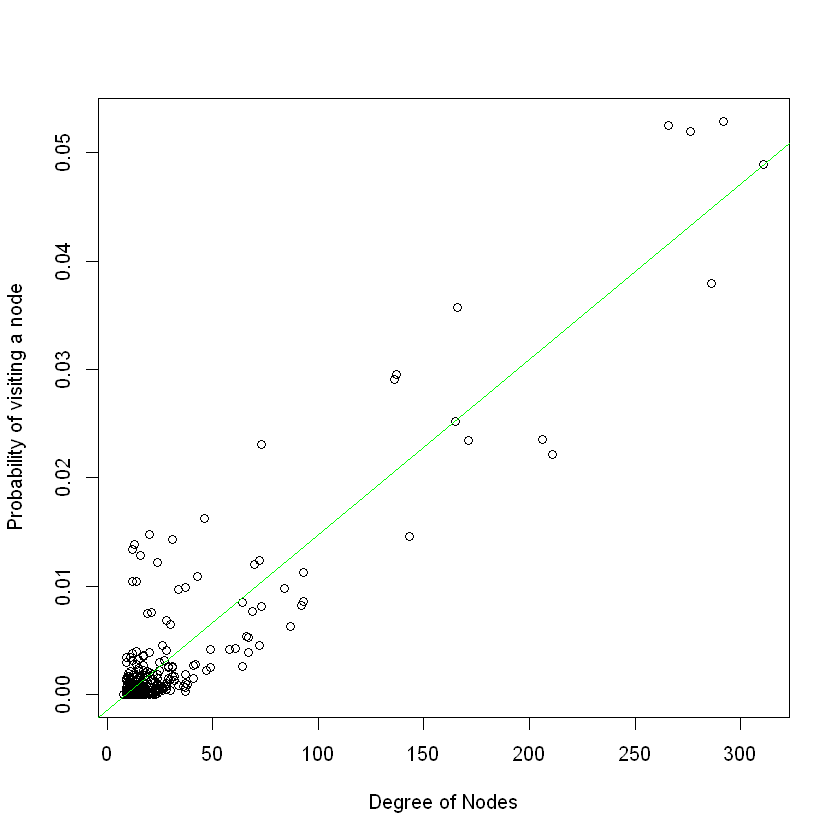

In [13]:
plot(degree(graph_combined), no_teleport_visit, xlab='Degree of Nodes', ylab='Probability of visiting a node')
abline(lm(no_teleport_visit ~ degree(graph_combined)), col="green")
print(cor(degree(graph_combined), no_teleport_visit))
print(lm(no_teleport_visit ~ degree(graph_combined)))

In [14]:
#b
alpha=0.20

In [15]:
equal_visit =count_simulate_random_walk(graph_combined, teleport_prob=alpha, teleport_mode="equal")

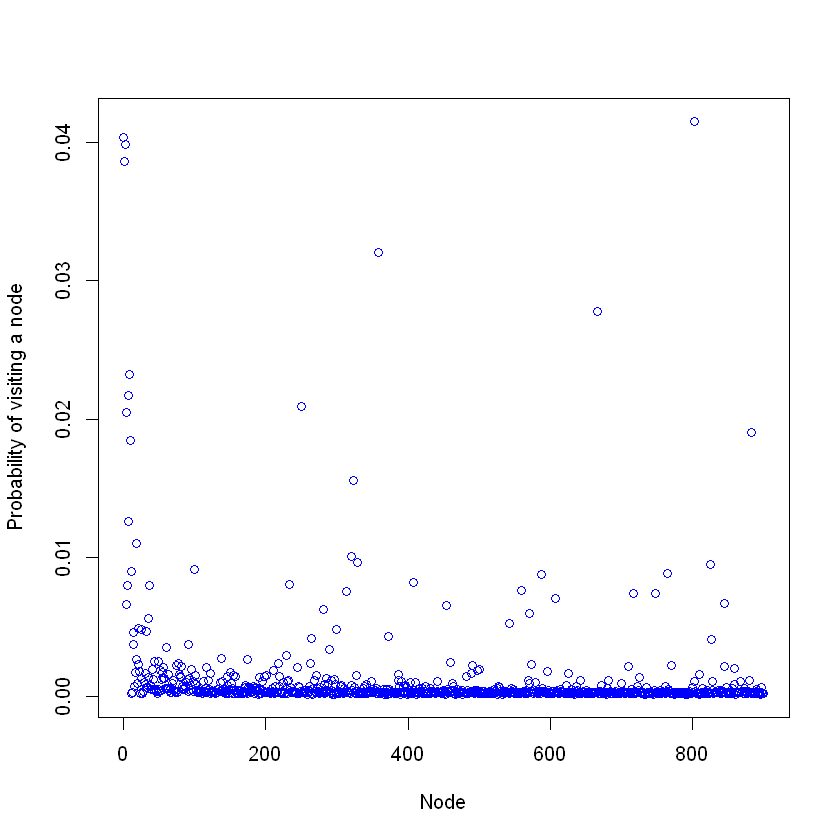

In [16]:
plot(equal_visit, xlab='Node', col = "blue", ylab='Probability of visiting a node')

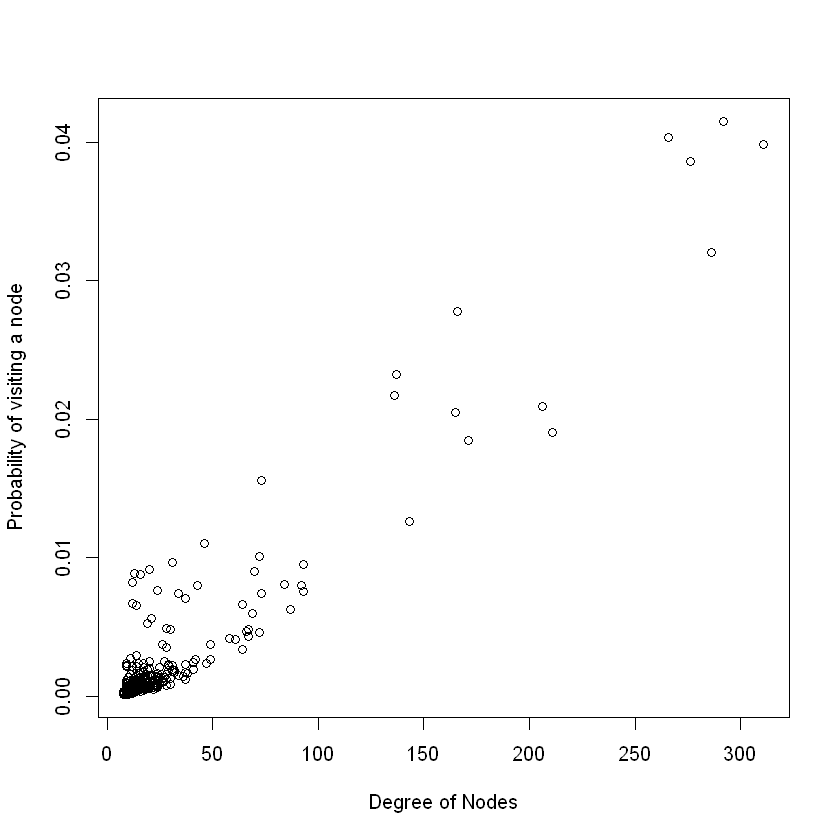

In [17]:
plot(degree(graph_combined), equal_visit, xlab='Degree of Nodes', ylab='Probability of visiting a node')

[1] 0.9491821

Call:
lm(formula = equal_visit ~ degree(graph_combined))

Coefficients:
           (Intercept)  degree(graph_combined)  
            -0.0009410               0.0001286  



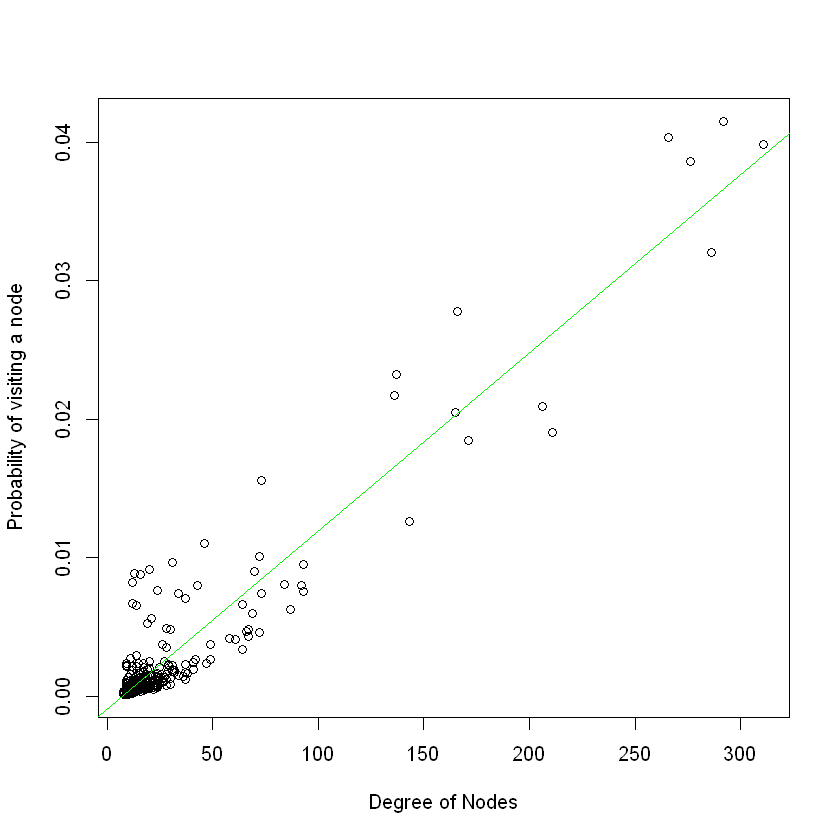

In [18]:
plot(degree(graph_combined), equal_visit, xlab='Degree of Nodes', ylab='Probability of visiting a node')
abline(lm(equal_visit ~ degree(graph_combined)), col="green")
print(cor(degree(graph_combined), equal_visit))
print(lm(equal_visit ~ degree(graph_combined)))

In [19]:
#Q4

In [20]:
page_rank_visit=count_simulate_random_walk(graph_combined, teleport_prob=alpha, teleport_mode="page_rank")

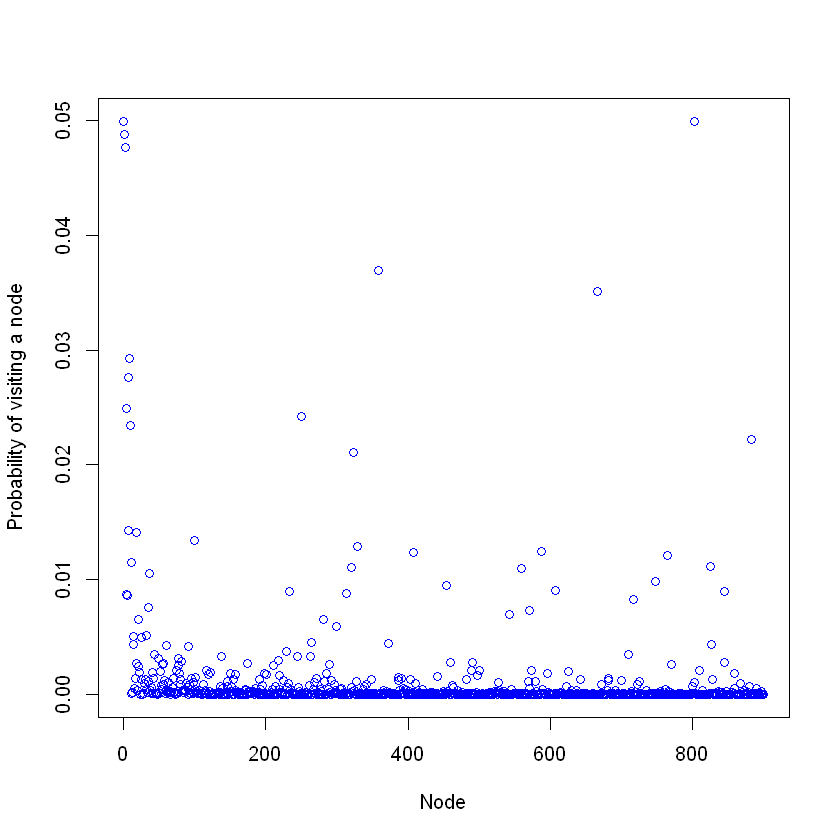

In [21]:
plot(page_rank_visit,col = "blue", xlab='Node', ylab='Probability of visiting a node')

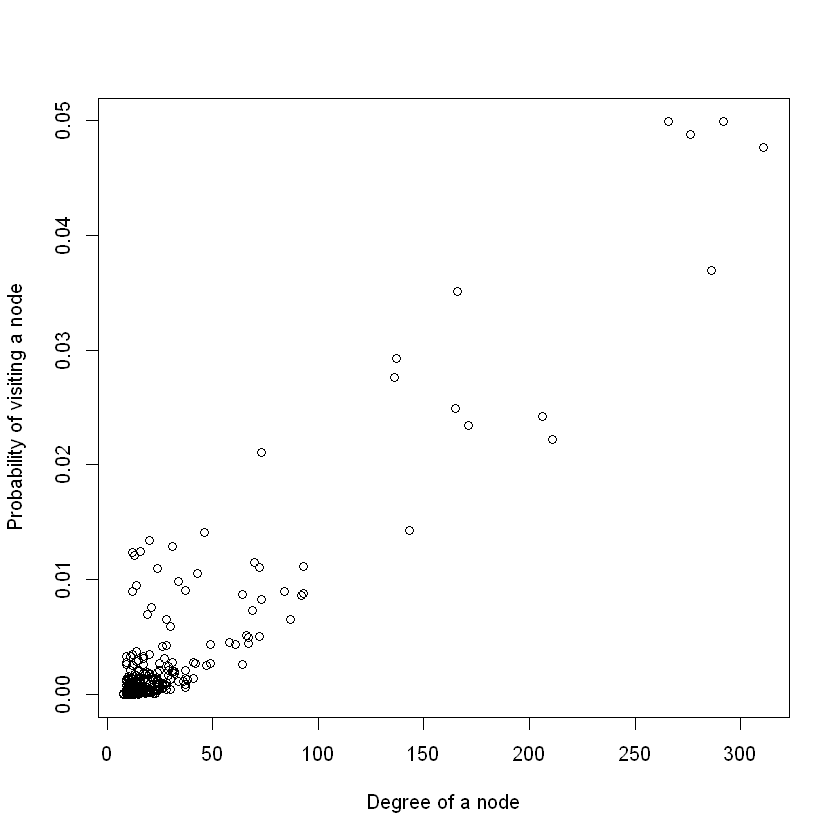

In [22]:
plot(degree(graph_combined), page_rank_visit, xlab='Degree of a node', ylab='Probability of visiting a node')

[1] 0.9306456

Call:
lm(formula = page_rank_visit ~ degree(graph_combined))

Coefficients:
           (Intercept)  degree(graph_combined)  
            -0.0013877               0.0001566  



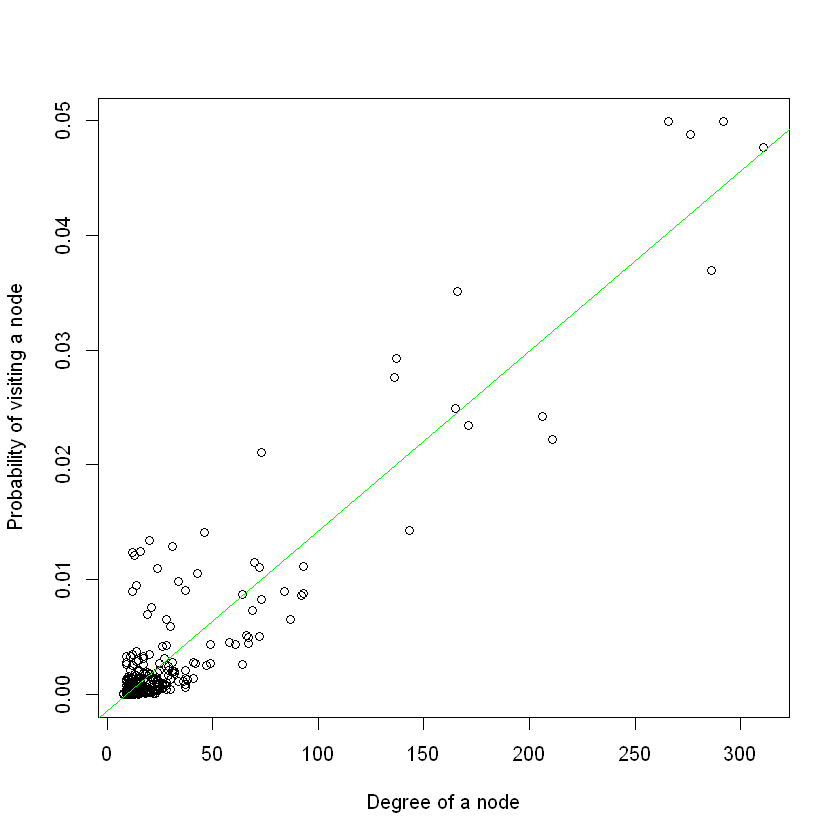

In [23]:
plot(degree(graph_combined), page_rank_visit, xlab='Degree of a node', ylab='Probability of visiting a node')
abline(lm(page_rank_visit ~ degree(graph_combined)), col="green")
print(cor(degree(graph_combined), page_rank_visit))
print(lm(page_rank_visit ~ degree(graph_combined)))

In [24]:
#b
page_rank_median_visit =count_simulate_random_walk(graph_combined, teleport_prob=alpha, teleport_mode="page_rank_median")

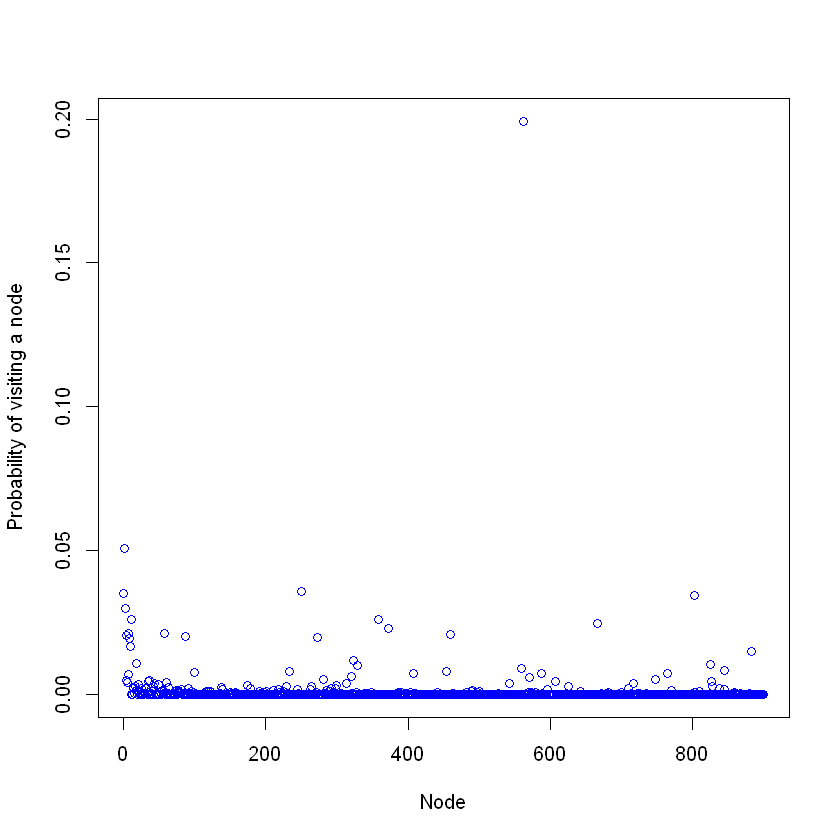

In [25]:
plot(page_rank_median_visit, col = "blue", xlab='Node', ylab='Probability of visiting a node')

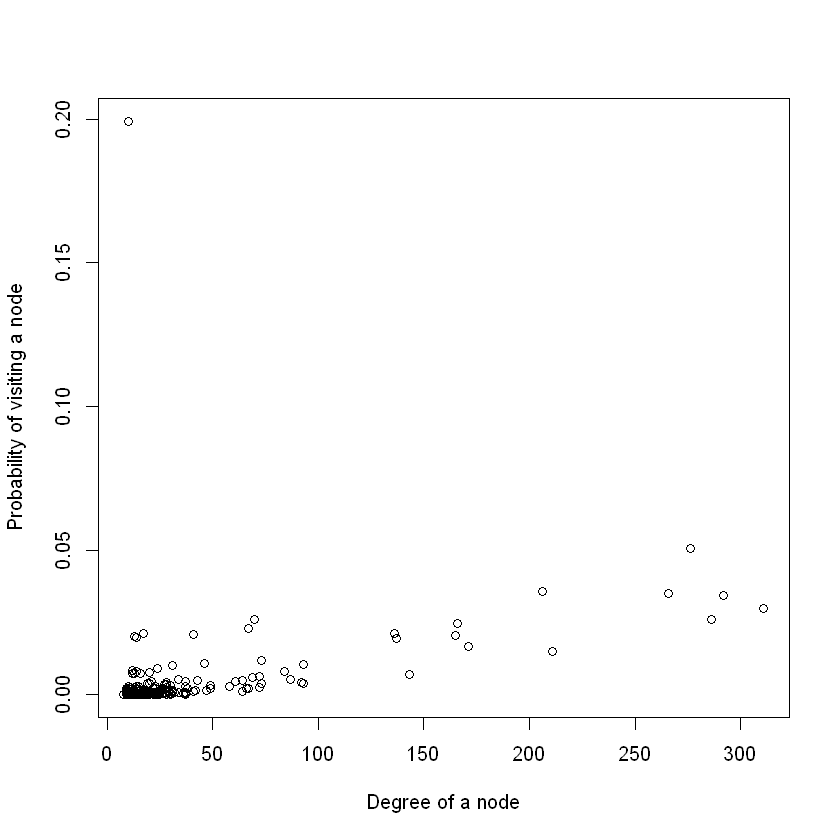

In [26]:
plot(degree(graph_combined), page_rank_median_visit, xlab='Degree of a node', ylab='Probability of visiting a node')

[1] 0.4280885

Call:
lm(formula = page_rank_median_visit ~ degree(graph_combined))

Coefficients:
           (Intercept)  degree(graph_combined)  
            -0.0008238               0.0001213  



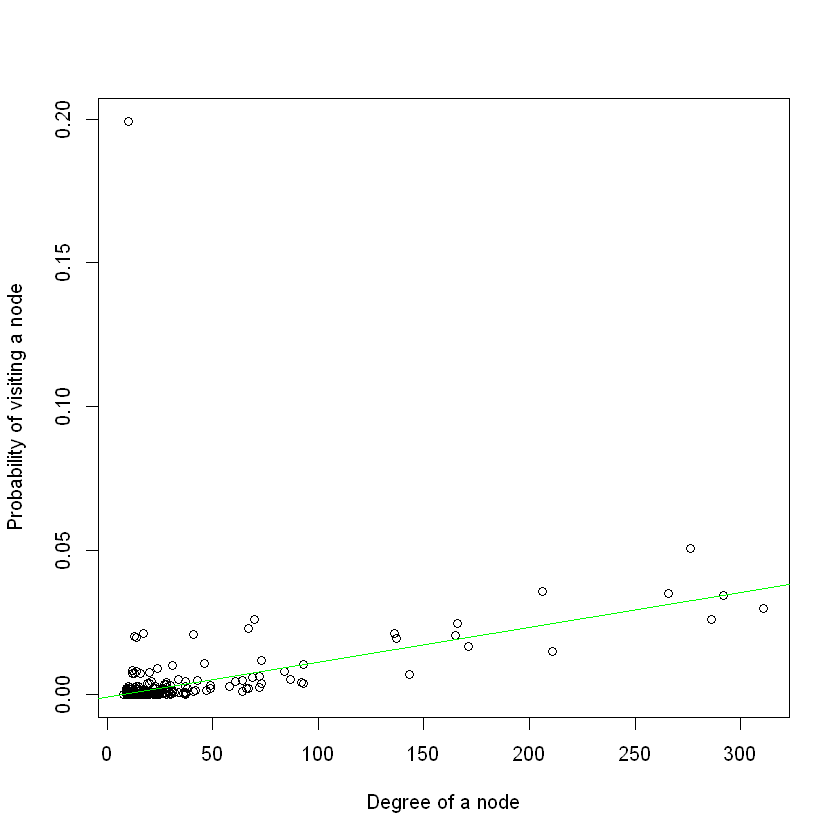

In [27]:
plot(degree(graph_combined), page_rank_median_visit, xlab='Degree of a node', ylab='Probability of visiting a node')
abline(lm(page_rank_median_visit ~ degree(graph_combined)), col="green")
print(cor(degree(graph_combined), page_rank_median_visit))
print(lm(page_rank_median_visit ~ degree(graph_combined)))

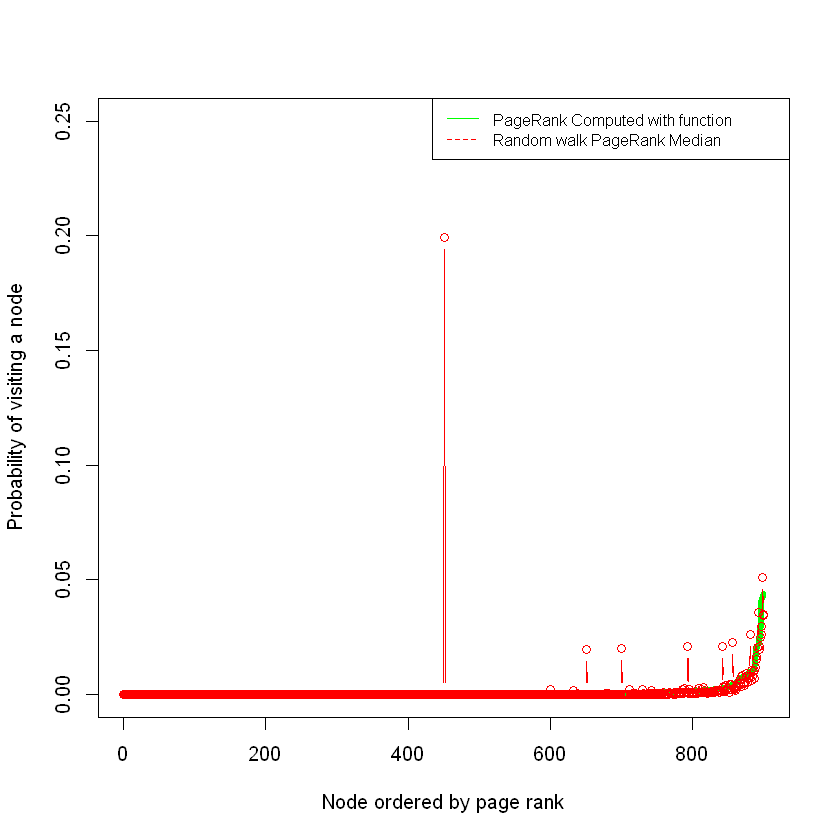

In [28]:
page_ranks = page_rank(graph_combined)$vector
plot(sort(page_ranks), col="green", type='l',lwd=5, ylim=c(0,0.25), xlab='Node ordered by page rank', ylab='Probability of visiting a node')
points(page_rank_median_visit[order(page_ranks)], col="red", type='b')
legend("topright", legend = c("PageRank Computed with function", "Random walk PageRank Median"), lty=1:2,col = c("green", "red"), cex=0.8)